## Reconstruction Error

In [191]:
NUM_SAMPLES = [25] # [10, 15, 20, 25]
RANKS = [2, 3, 4, 5, 6]
WORKLOADS = ["real-estate", "biodex"]
WORKLOAD_TO_LOGICAL_OP_IDS = {
    "real-estate": ["f069c376dc"],
    "biodex": [''],
}
NUM_TRIALS = 100

### Load Groundtruth Execution Data

In [192]:
import json
import numpy as np

workload_to_sentinel_plan_id = {
    "real-estate": (100, "4f754e3b01"),
    "biodex": None,
}

# STORE MAPPING FROM NUMBER OF SAMPLES --> GROUNDTRUTH DATA
workload_to_raw_matrices = {workload: {} for workload in WORKLOADS}
for workload, tup in workload_to_sentinel_plan_id.items():
    if workload == "biodex":
        continue

    n, plan_id = tup
    raw_matrices_fp = f"opt-profiling-data/raw-matrices-n-{n}-{plan_id}.json"
    with open(raw_matrices_fp, 'r') as f:
        # load mapping from logical_op_id --> (per-metric) matrices
        raw_matrices = json.load(f)

        # convert serialized matrices back into numpy arrays
        for logical_op_id, matrices_dict in raw_matrices.items():
            if logical_op_id not in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                continue

            metric_to_matrix = {}
            for metric, matrix in matrices_dict.items():
                # ignore selectivity for now
                if metric == "selectivity":
                    continue

                matrix = np.array(matrix)

                # remove code synth column from real-estate to match other workloads
                if workload == "real-estate":
                    matrix = np.delete(matrix, 3, axis=0)

                metric_to_matrix[metric] = np.array(matrix)

            raw_matrices[logical_op_id] = metric_to_matrix

        # store dictionary of arrays
        workload_to_raw_matrices[workload] = raw_matrices


### Define Helpers

In [193]:
import numpy as np

def create_sample_matrix(num_rows: int, num_cols: int, rank: int, seed: int):
    """
    Compute the observation matrix which will determine which optimizations (cols)
    are applied to which records (rows).
    """
    # if there are fewer physical operators than the rank + 1 for this operation, then every
    # operation must execute on every record
    if num_cols <= rank + 1:
        return np.ones((num_rows, num_cols))

    # otherwise, we construct an observation matrix which is guaranteed to
    # have rank + 1 samples per column and per row
    sample_matrix = np.zeros((num_rows, num_cols))

    # construct matrix in a way that guarantees rank + 1 samples per column,
    # with minimal overlap across rows
    start_idx = 0
    for col in range(num_cols):
        end_idx = (start_idx + rank + 1) % num_rows
        if end_idx > start_idx:
            sample_matrix[start_idx:end_idx, col] = 1
        else:
            sample_matrix[start_idx:num_rows, col] = 1
            sample_matrix[0:end_idx, col] = 1
        start_idx = (end_idx - 1) % num_rows

    # go row-by-row and add samples until all rows also have rank + 1 samples per row
    row_sums = np.sum(sample_matrix, axis=1)
    col = 0
    for row in range(num_rows):
        row_sum = row_sums[row]
        while row_sum < rank + 1:
            if sample_matrix[row, col] == 0:
                sample_matrix[row, col] = 1
                row_sum += 1
            col = (col + 1) % num_cols

    # finally shuffle the rows and columns of the sample matrix
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(sample_matrix, axis=0)

    return sample_matrix

In [194]:
import torch
import numpy as np
from tqdm import tqdm
from typing import Dict


def exp_complete_matrix(true_mat, mat_mask, rank):
    device = "cpu"
    num_rows, num_cols = true_mat.shape

    X = torch.empty((num_rows, rank), requires_grad=True)
    torch.nn.init.normal_(X)
    Y = torch.empty((rank, num_cols), requires_grad=True)
    torch.nn.init.normal_(Y)

    mse_loss = torch.nn.MSELoss()
    opt_X = torch.optim.Adam([X], lr=1e-3, weight_decay=1e-5)
    opt_Y = torch.optim.Adam([Y], lr=1e-3, weight_decay=1e-5)
    opt_X_scheduler = torch.optim.lr_scheduler.StepLR(opt_X, step_size=1000, gamma=0.9)
    opt_Y_scheduler = torch.optim.lr_scheduler.StepLR(opt_Y, step_size=1000, gamma=0.9)

    # create tensors for mat mask and true_matrix
    mat_mask = torch.tensor(mat_mask, dtype=bool)
    true_matrix = torch.as_tensor(true_mat, dtype=torch.float32, device=device)

    # # compute matrix mean and std
    # true_mean = true_matrix[mat_mask].mean()
    # true_std = true_matrix[mat_mask].std()

    # compute column means and std deviations
    true_col_means = torch.tensor(np.mean(true_mat, axis=0, where=mat_mask), dtype=torch.float32, device=device)
    true_col_stds = torch.tensor(np.std(true_mat, axis=0, where=mat_mask), dtype=torch.float32, device=device)

    # in some cases we may have zero variance in ALL of our observed sample data;
    # in this case, the rationale way to complete the matrix is to assume
    # it is rank = 1 and every data point is equal to the true_mean
    if (true_col_stds == 0.0).all():
        R = torch.zeros((true_matrix.shape))
        R[:, :] = true_col_means
        return R.detach().numpy(), [], [], []

    # if we have some columns with 0 variance:
    # 1. set their true_col_stds entries equal to 1;
    #    a. this will ensure that these entries are not scaled, but still have their mean translation
    # 2. (TURNED OFF) update the mat_mask to include these values
    #    a. subtraction of the column mean --> that every entry will be 0.0
    #    b. by adding these entries to the mask, we encourage the factorized matrix to respect these constraints
    zero_variance_cols = (true_col_stds == 0.0)
    true_col_stds[zero_variance_cols] = 1.0
    # mat_mask[:,zero_variance_cols] = True

    # otherwise, scale the matrix and learn factor matrices
    scaled_true_matrix = (true_matrix - true_col_means)/true_col_stds

    # # precompute column means for scaled_true_matrix
    # scaled_true_masked_matrix = torch.masked.masked_tensor(scaled_true_matrix, mat_mask)

    # # NOTE: np.nan fills masked values, but this tensor should not have any
    # scaled_true_col_means = scaled_true_masked_matrix.mean(dim=0).to_tensor(np.nan)
    losses, recon_losses, col_losses = [], [], []
    for _ in range(5000):
        opt_X.zero_grad()
        opt_Y.zero_grad()

        # compute matrix reconstruction
        R = torch.matmul(X,Y)

        # loss for reconstructing groundtruth values
        recon_loss = mse_loss(R[mat_mask], scaled_true_matrix[mat_mask])

        # loss for sending means far from scaled values (which are all 0.0)
        col_loss = mse_loss(R.mean(dim=0), torch.zeros(true_col_means.shape, dtype=torch.float32, device=device))

        # compute loss as weighted average of contributions
        alpha = 0.5
        recon_loss_contribution = (1 - alpha) * recon_loss
        col_loss_contribution = alpha * col_loss
        loss = recon_loss_contribution + col_loss_contribution
        # loss = mse_loss(torch.matmul(X,Y)[mat_mask], true_matrix[mat_mask])

        loss.backward()

        losses.append(loss.item())
        recon_losses.append(recon_loss_contribution.item())
        col_losses.append(col_loss_contribution.item())

        opt_X.step()
        opt_Y.step()
        opt_X_scheduler.step()
        opt_Y_scheduler.step()
        
        # with torch.no_grad():
        #     X[:] = X.clamp_(min=0)
        #     Y[:] = Y.clamp_(min=0)

    # compute reconstruction
    R = torch.matmul(X, Y)

    # scale back to original mean and variance
    R_scaled = R * true_col_stds + true_col_means

    # TODO: Undo this?
    # # for any columns which had 0 variance, set their reconstructed values equal to that column mean
    # R_scaled[:, zero_variance_cols] = true_col_means[zero_variance_cols]

    return R_scaled.detach().numpy(), losses, recon_losses, col_losses


def complete_matrix(
        matrix: np.array,
        sample_mask: np.array,
        rank: int,
        metric: str,
    ):
    # if sample_mask is all 1's, no need to complete the matrix (it already is complete)
    if (sample_mask == 1.0).all():
        return matrices

    # ensure that matrix has float dtype (not int)
    matrix = matrix.astype(float)

    # complete the matrix
    completed_matrix, losses, recon_losses, col_losses = exp_complete_matrix(matrix, sample_mask, rank)

    # only update matrix entries for which we did not have samples
    # matrix[~sample_mask.astype(bool)] = completed_matrix[~sample_mask.astype(bool)]
    completed_matrix[sample_mask.astype(bool)] = matrix[sample_mask.astype(bool)]

    # clamp all matrices to be non-negative
    completed_matrix = np.clip(completed_matrix, 0.0, None)

    # clamp quality matrix to be less than 1.0
    if metric == "quality":
        completed_matrix = np.clip(completed_matrix, 0.0, 1.0)

    return completed_matrix, losses, recon_losses, col_losses


In [195]:
def run_trial(n, rank, raw_matrices_dict, trial_idx):
    # compute seed for all rngs
    seed = np.abs(hash(f"{n}-{rank}-{trial_idx}"))

    # get the dimensions of the raw matrix
    raw_num_rows, raw_num_cols = raw_matrices_dict["cost"].shape

    # randomly subsample n rows from the raw matrix to treat as a validation set
    rng = np.random.default_rng(seed=seed)
    val_row_indices = rng.choice(np.arange(raw_num_rows), size=n, replace=False)

    # -- create masks for random sampling --
    # from these rows, randomly subsample r+1 fully sampled rows
    random_fixed_row_indices = rng.choice(val_row_indices, size=rank+1, replace=False)
    random_fixed_row_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    random_fixed_row_sample_mask[random_fixed_row_indices, :] = 1

    # as a separate evaluation, fully sample 1 row, and then randomly sample the remaining r*m
    random_full_row_index = rng.choice(val_row_indices, size=1)
    random_any_entry_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    random_any_entry_sample_mask[random_full_row_index, :] = 1
    potential_entries = np.array([
        (row, col)
        for row in val_row_indices
        for col in np.arange(raw_num_cols)
        if row not in random_full_row_index
    ])
    sampled_entries = rng.choice(potential_entries, size=rank*raw_num_cols, replace=False)
    for row, col in sampled_entries:
        random_any_entry_sample_mask[row, col] = 1

    # create a sample matrix; every raw matrix will have the shape (n, num_cols),
    # where num_cols is determined by the raw matrix
    num_rows, num_cols = n, raw_matrices_dict["cost"].shape[1]

    # create a sample mask for our matrix completion; here we assume that
    # we use the n validation rows and sample with rank r
    sample_mask = create_sample_matrix(n, raw_num_cols, rank, seed=seed)

    # run matrix completion for each metric
    completed_matrices = {}
    losses, recon_losses, col_losses = {}, {}, {}
    for metric in ["cost", "time", "quality"]:
        # get subset of raw matrix which is treated as validation data
        raw_matrix = raw_matrices_dict[metric]
        val_matrix = raw_matrix[val_row_indices, :]
        completed_matrix, losses_, recon_losses_, col_losses_ = complete_matrix(val_matrix, sample_mask, rank, metric)
        completed_matrices[metric] = completed_matrix
        losses[metric] = losses_
        recon_losses[metric] = recon_losses_
        col_losses[metric] = col_losses_

    return completed_matrices, sample_mask, random_fixed_row_sample_mask, random_any_entry_sample_mask, losses, recon_losses, col_losses


## Run Experiments

In [196]:
# setup output data structures
d = {
    workload: {
        n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
        for n in NUM_SAMPLES
    }
    for workload in WORKLOADS
}
completed_matrix_data = d.copy()
completed_matrix_data_copy = d.copy()
completed_matrix_sample_masks = d.copy()
completed_matrix_sample_masks_copy = d.copy()
random_fixed_row_sample_masks = d.copy()
random_fixed_row_sample_masks_copy = d.copy()
random_any_entry_sample_masks = d.copy()
random_any_entry_sample_masks_copy = d.copy()


In [ ]:
# from concurrent.futures import ThreadPoolExecutor
import os
os.makedirs("cached-matrices", exist_ok=True)

# generate a bunch of data from many matrix completions
all_losses, all_recon_losses, all_col_losses = [], [], []
for workload in WORKLOADS:
    if workload == "biodex":
        continue
    for n in tqdm(NUM_SAMPLES, position=0, leave=True):
        for rank in tqdm(RANKS, position=1, leave=True):
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth mapping from metric --> execution_data
                raw_matrices = workload_to_raw_matrices[workload][logical_op_id]

                # run NUM_TRIALS trials
                torch.set_num_threads(35)
                for trial_idx in tqdm(range(NUM_TRIALS), position=2, leave=True):
                    output = run_trial(n, rank, raw_matrices, trial_idx)
                    completed_matrices, sample_mask = output[0], output[1]
                    random_fixed_row_sample_mask, random_any_entry_sample_mask = output[2], output[3]
                    losses, recon_losses, col_losses = output[4], output[5], output[6]

                    completed_matrix_data[workload][n][rank][logical_op_id].append(completed_matrices)
                    completed_matrix_data_copy[workload][n][rank][logical_op_id].append(
                          {k: v.tolist() for k, v in completed_matrices.items()}
                    )
                    completed_matrix_sample_masks[workload][n][rank][logical_op_id].append(sample_mask)
                    completed_matrix_sample_masks_copy[workload][n][rank][logical_op_id].append(sample_mask.tolist())

                    random_fixed_row_sample_masks[workload][n][rank][logical_op_id].append(random_fixed_row_sample_mask)
                    random_fixed_row_sample_masks_copy[workload][n][rank][logical_op_id].append(random_fixed_row_sample_mask.tolist())

                    random_any_entry_sample_masks[workload][n][rank][logical_op_id].append(random_any_entry_sample_mask)
                    random_any_entry_sample_masks_copy[workload][n][rank][logical_op_id].append(random_any_entry_sample_mask.tolist())

                    # track losses as well
                    all_losses.append(losses)
                    all_recon_losses.append(recon_losses)
                    all_col_losses.append(col_losses)

    with open(f"cached-matrices/{workload}-cached-random-matrices.json", "w") as f:
        json.dump(random_matrix_data_copy[workload], f)
    
    with open(f"cached-matrices/{workload}-cached-completed-matrices.json", "w") as f:
        json.dump(completed_matrix_data_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-completed-matrices-sample-masks.json", "w") as f:
        json.dump(completed_matrix_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-random-fixed-row-sample-masks.json", "w") as f:
        json.dump(random_fixed_row_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-random-any-entry-sample-masks.json", "w") as f:
        json.dump(random_any_entry_sample_masks_copy[workload], f)

  0%|                                                                                                                                       | 0/5 [00:00<?, ?it/s]

  0%|                                                                                                                                     | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                           | 1/100 [00:06<10:02,  6.08s/it]

  2%|██▌                                                                                                                          | 2/100 [00:12<10:09,  6.22s/it]

  3%|███▊                                                                                                                         | 3/100 [00:18<09:57,  6.16s/it]

  4%|█████                                                                                                                        | 4/100 [00:24<09:48,  6.13s/it]

  5%|██████▎    

In [15]:
# TODO: fix for multi-workloads

# with open("cached-completed-matrices.json", "r") as f:
#     completed_matrix_data_ = json.load(f)

# with open("cached-completed-matrices-sample-masks.json", "r") as f:
#     completed_matrix_sample_masks_ = json.load(f)

# completed_matrix_data = {
#     n: {rank: {logical_op_id: [] for logical_op_id in LOGICAL_OP_IDS} for rank in RANKS}
#     for n in NUM_SAMPLES
# }
# completed_matrix_sample_masks = {
#     n: {rank: {logical_op_id: [] for logical_op_id in LOGICAL_OP_IDS} for rank in RANKS}
#     for n in NUM_SAMPLES
# }

# for n in NUM_SAMPLES:
#     for rank in RANKS:
#         if rank + 1 > n:
#             continue
#         for logical_op_id in LOGICAL_OP_IDS:
            
#             completed_matrix_data[n][rank][logical_op_id] = [
#                 {metric: np.array(arr) for metric, arr in completed_matrix_data_[str(n)][str(rank)][logical_op_id][trial_idx].items()}
#                 for trial_idx in range(NUM_TRIALS)
#             ]
#             completed_matrix_sample_masks[n][rank][logical_op_id] = [
#                 np.array(completed_matrix_sample_masks_[str(n)][str(rank)][logical_op_id][trial_idx])
#                 for trial_idx in range(NUM_TRIALS)
#             ]

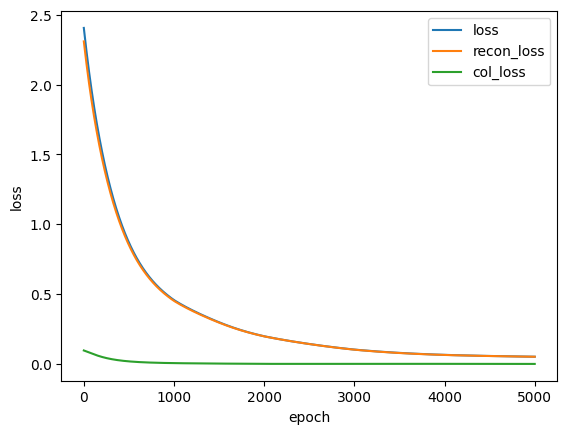

In [134]:
fig, ax = plt.subplots()
trial_idx = 0
metric = 'time'
losses = all_losses[trial_idx][metric]
recon_losses = all_recon_losses[trial_idx][metric]
col_losses = all_col_losses[trial_idx][metric]

ax.plot([idx for idx in range(len(losses))], losses, label="loss")
ax.plot([idx for idx in range(len(recon_losses))], recon_losses, label="recon_loss")
ax.plot([idx for idx in range(len(col_losses))], col_losses, label="col_loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [171]:
import scipy.stats as stats

error_data = []
for workload in WORKLOADS:
    if workload == "biodex":
        continue
    for n in NUM_SAMPLES:
        for rank in RANKS:
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth matrix data
                raw_matrices = workload_to_raw_matrices[workload][logical_op_id]

                for trial_idx in range(NUM_TRIALS):
                    # get the sample mask for this trial
                    sample_mask = completed_matrix_sample_masks[workload][n][rank][logical_op_id][trial_idx]

                    # compute mean percent error of estimations
                    for metric in ["cost", "time", "quality"]:
                        # groundtruth matrix
                        raw_matrix = raw_matrices[metric]

                        # completed matrix
                        completed_matrix = completed_matrix_data[workload][n][rank][logical_op_id][trial_idx][metric]

                        # random matrix
                        random_matrix = random_matrix_data[workload][n][rank][logical_op_id][trial_idx][metric]

                        # compute groundtruth estimates of (per-operator) metric
                        true_col_means = np.mean(raw_matrix, axis=0)

                        # compute reconstructed estimates of (per-operator) metric
                        est_col_means = np.mean(completed_matrix, axis=0)#, where=sample_mask.astype(bool))

                        # compute random sample estimates of (per-operator) metric
                        est_random_means = np.mean(random_matrix, axis=0)

                        # remove code synth from real-estate
                        if workload == "real-estate":
                            est_col_means = np.delete(est_col_means, 3, axis=0)
                            est_random_means = np.delete(est_random_means, 3, axis=0)
                            true_col_means = np.delete(true_col_means, 3, axis=0)

                        # compute error from mean divided by size of mean
                        mean_pct_error = np.mean(np.abs(est_col_means - true_col_means)/true_col_means)
                        random_mean_pct_error = np.mean(np.abs(est_random_means - true_col_means)/true_col_means)

                        # construct one record for our estimate and one record for the random sampling estimate
                        pz_obs = {
                            "workload": workload, "num_samples": n, "rank": rank, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "pz", "mean_pct_error": mean_pct_error,
                        }
                        random_obs = {
                            "workload": workload, "num_samples": n, "rank": rank, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "random", "mean_pct_error": random_mean_pct_error,
                        }
                        error_data.extend([pz_obs, random_obs])


In [ ]:
import scipy.stats as stats

# error_data = []
for workload in WORKLOADS:
    if workload == "biodex":
        continue
    for n in NUM_SAMPLES:
        for rank in RANKS:
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth matrix data
                raw_matrices = workload_to_raw_matrices[workload][logical_op_id]

                for trial_idx in range(NUM_TRIALS):
                    # get the sample mask for this trial
                    sample_mask = completed_matrix_sample_masks[workload][n][rank][logical_op_id][trial_idx]

                    # compute mean percent error of estimations
                    for metric in ["cost", "time", "quality"]:
                        # groundtruth matrix
                        raw_matrix = raw_matrices[metric]

                        # compute seed for all rngs
                        seed = np.abs(hash(f"{n}-{rank}-{trial_idx}"))
                    
                        # get the dimensions of the raw matrix
                        raw_num_rows, raw_num_cols = raw_matrix.shape

                        # randomly subsample n rows from the raw matrix to treat as a validation set
                        rng = np.random.default_rng(seed=seed)
                        val_row_indices = rng.choice(np.arange(raw_num_rows), size=n, replace=False)
                    
                        # from these rows, randomly subsample r+1 rows for random sampling, and fully sample these rows
                        random_row_indices = rng.choice(val_row_indices, size=rank+1, replace=False)
                        really_random_matrix = rng.choice( size=)
                        for metric in ["cost", "time", "quality"]:
                            random_matrix = raw_matrices_dict[metric][random_row_indices, :]
                            random_matrices[metric] = random_matrix


                        # really random matrix
                        # really_random_matrix = random_matrix_data[workload][n][rank][logical_op_id][trial_idx][metric]
                        really_random_matrix

                        # compute groundtruth estimates of (per-operator) metric
                        true_col_means = np.mean(raw_matrix, axis=0)

                        # compute random sample estimates of (per-operator) metric
                        est_really_random_means = np.mean(really_random_matrix, axis=0)

                        # remove code synth from real-estate
                        if workload == "real-estate":
                            est_col_means = np.delete(est_col_means, 3, axis=0)
                            est_really_random_means = np.delete(est_random_means, 3, axis=0)
                            true_col_means = np.delete(true_col_means, 3, axis=0)

                        # compute error from mean divided by size of mean
                        really_random_mean_pct_error = np.mean(np.abs(est_really_random_means - true_col_means)/true_col_means)

                        # construct one record for our estimate and one record for the random sampling estimate
                        really_random_obs = {
                            "workload": workload, "num_samples": n, "rank": rank, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "really-random",
                            "mean_pct_error": really_random_mean_pct_error,
                        }
                        error_data.extend([really_random_obs])


In [172]:
import pandas as pd

error_df = pd.DataFrame(error_data)

In [173]:
error_df.to_csv("opt-results/real_estate_error_data_100_trials_new_exp.csv", index=False)

In [174]:
error_df[error_df.metric=="quality"].groupby("label").mean("mean_pct_error")

,num_samples,rank,trial_idx,mean_pct_error
label,,,,
pz,17.5,4.0,49.5,0.005162
random,17.5,4.0,49.5,0.000577


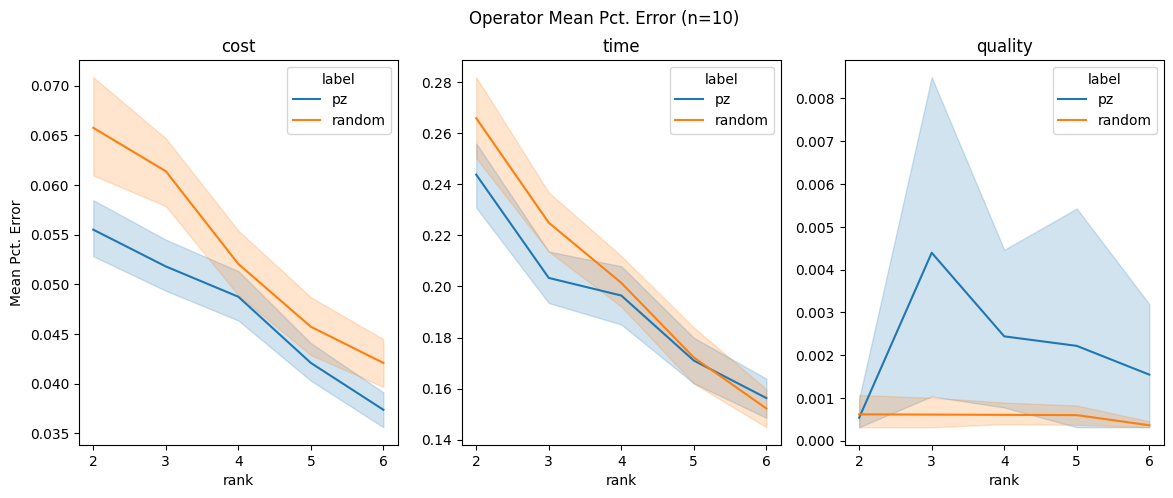

In [182]:
import matplotlib.pyplot as plt
import seaborn as sn

n = 10
workload = "real-estate"
fig1, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, metric in enumerate(["cost", "time", "quality"]):
    results_df = error_df[(error_df.num_samples == n) & (error_df.workload == workload) & (error_df.metric == metric)]
    g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
    g.set_title(metric)
    if idx == 0:
        g.set_ylabel("Mean Pct. Error")
    else:
        g.set_ylabel(None)
fig1.suptitle(f"Operator Mean Pct. Error (n={n})")
fig1.savefig(f"opt-results/{workload}-error-num-samples-{n}.png")

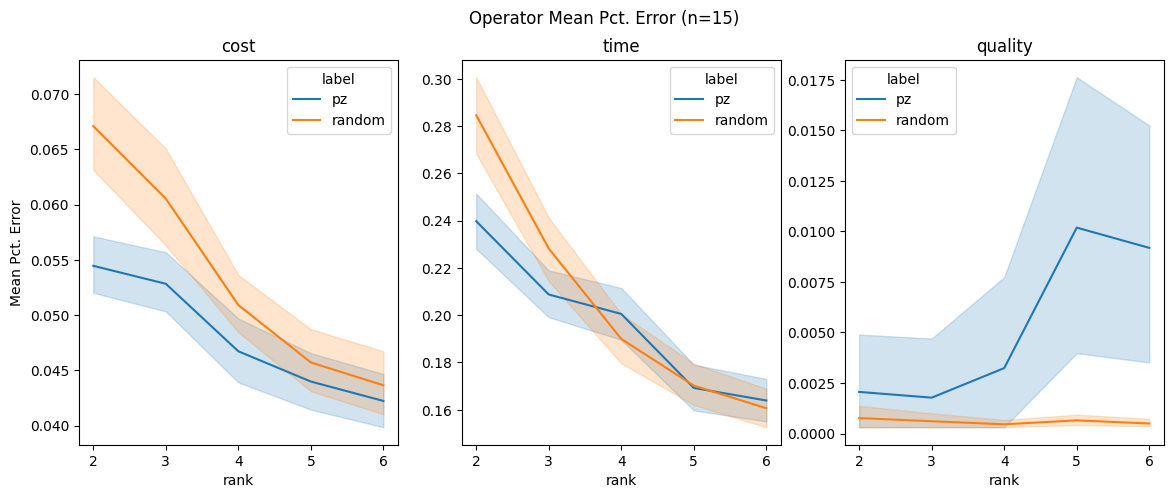

In [183]:
import matplotlib.pyplot as plt
import seaborn as sn

n = 15
workload = "real-estate"
fig1, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, metric in enumerate(["cost", "time", "quality"]):
    results_df = error_df[(error_df.num_samples == n) & (error_df.workload == workload) & (error_df.metric == metric)]
    g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
    g.set_title(metric)
    if idx == 0:
        g.set_ylabel("Mean Pct. Error")
    else:
        g.set_ylabel(None)
fig1.suptitle(f"Operator Mean Pct. Error (n={n})")
fig1.savefig(f"opt-results/{workload}-error-num-samples-{n}.png")

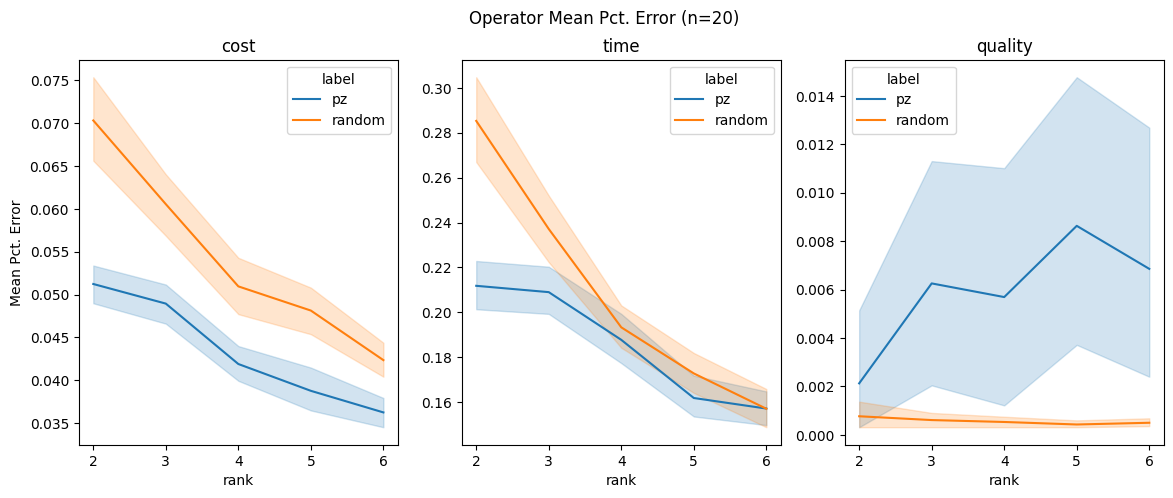

In [184]:
import matplotlib.pyplot as plt
import seaborn as sn

n = 20
workload = "real-estate"
fig1, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, metric in enumerate(["cost", "time", "quality"]):
    results_df = error_df[(error_df.num_samples == n) & (error_df.workload == workload) & (error_df.metric == metric)]
    g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
    g.set_title(metric)
    if idx == 0:
        g.set_ylabel("Mean Pct. Error")
    else:
        g.set_ylabel(None)
fig1.suptitle(f"Operator Mean Pct. Error (n={n})")
fig1.savefig(f"opt-results/{workload}-error-num-samples-{n}.png")

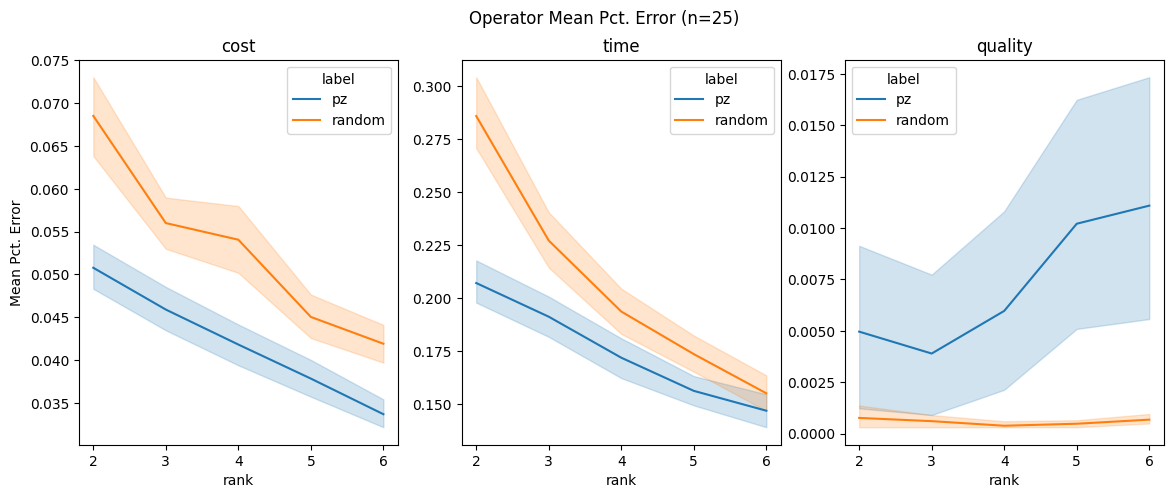

In [181]:
import matplotlib.pyplot as plt
import seaborn as sn

n = 25
workload = "real-estate"
fig1, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, metric in enumerate(["cost", "time", "quality"]):
    results_df = error_df[(error_df.num_samples == n) & (error_df.workload == workload) & (error_df.metric == metric)]
    g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
    g.set_title(metric)
    if idx == 0:
        g.set_ylabel("Mean Pct. Error")
    else:
        g.set_ylabel(None)
fig1.suptitle(f"Operator Mean Pct. Error (n={n})")
fig1.savefig(f"opt-results/{workload}-error-num-samples-{n}.png")


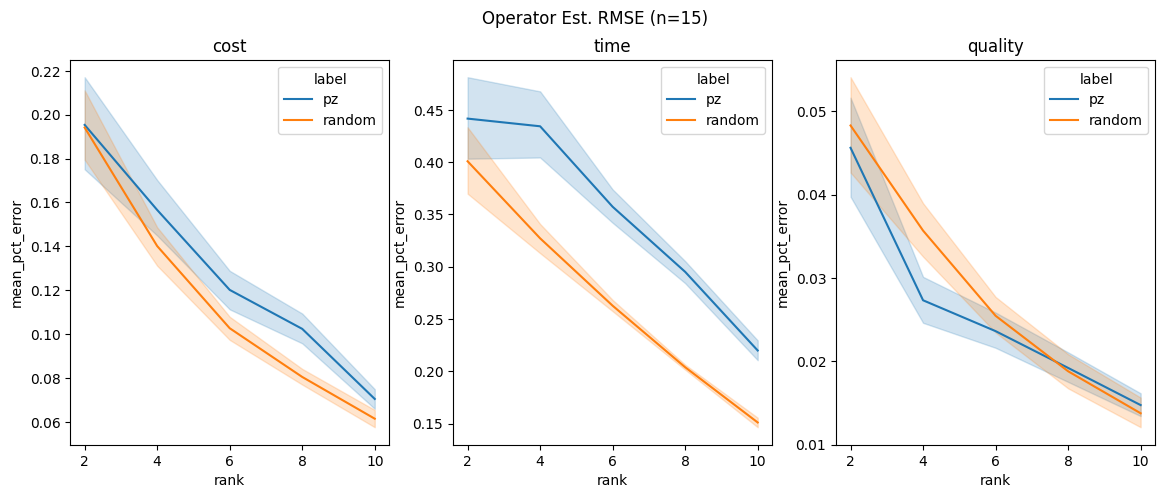

In [659]:
import matplotlib.pyplot as plt
import seaborn as sn

fig2, axs = plt.subplots(1, 3, figsize=(14, 5))
for n in [15]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig2.suptitle(f"Operator Est. RMSE (n={n})")
    fig2.savefig(f"opt-results/error-num-samples-{n}.png")

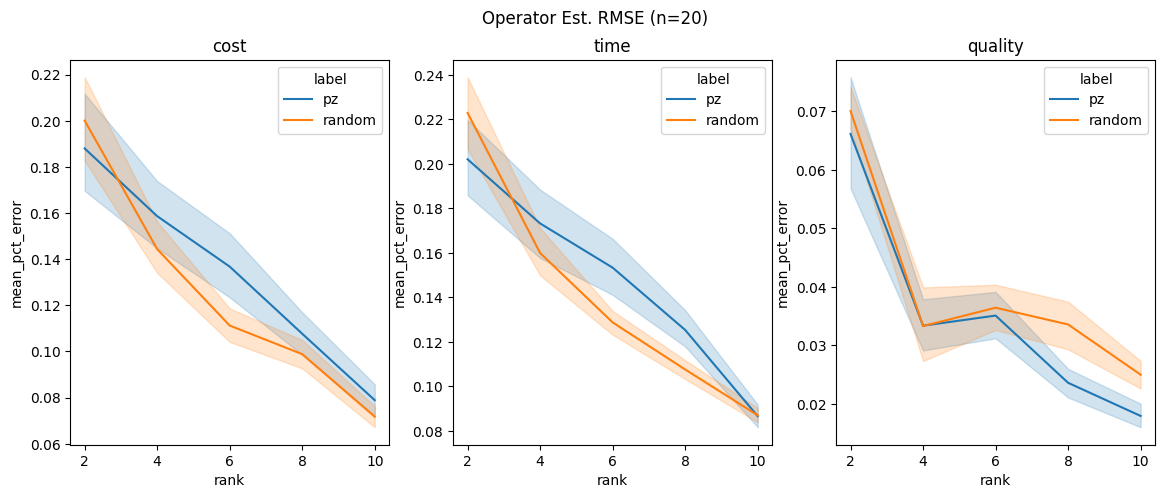

In [660]:
import matplotlib.pyplot as plt
import seaborn as sn

fig3, axs = plt.subplots(1, 3, figsize=(14, 5))
for n in [20]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig3.suptitle(f"Operator Est. RMSE (n={n})")
    fig3.savefig(f"opt-results/error-num-samples-{n}.png")

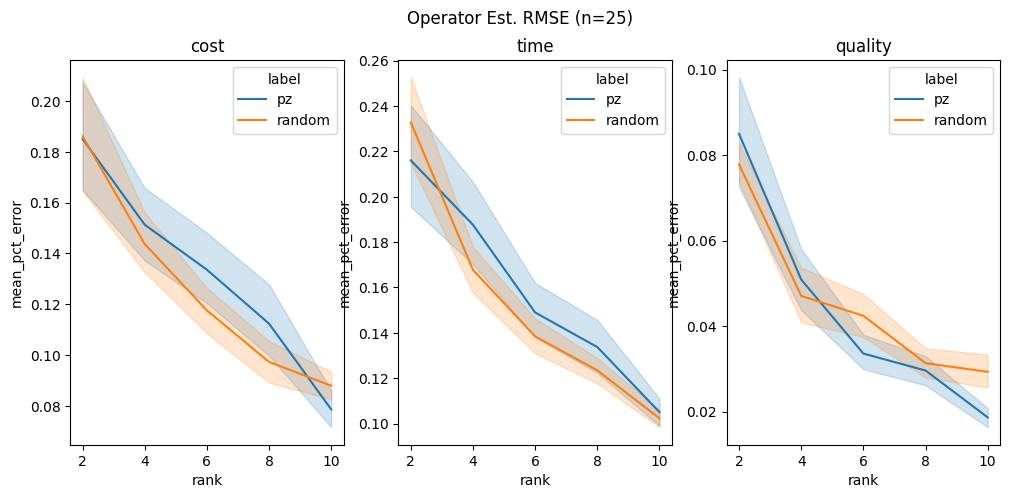

In [663]:
import matplotlib.pyplot as plt
import seaborn as sn

fig4, axs = plt.subplots(1, 3, figsize=(12, 5))
for n in [25]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig4.suptitle(f"Operator Est. RMSE (n={n})")
    fig4.savefig(f"opt-results/error-num-samples-{n}.png")

## Exploration

In [223]:
np.set_printoptions(precision=5, linewidth=250)

In [29]:
def run_trial_with_losses(rank, raw_matrices_dict, trial_idx):
    # only use single torch thread
    torch.set_num_threads(2)

    # create a sample matrix; every raw matrix will have the same shape for a given logical_op_id;
    # we use the "cost" matrix to get the shape
    num_rows, num_cols = raw_matrices_dict["cost"].shape

    # create a sample mask
    sample_mask = create_sample_matrix(num_rows, num_cols, rank, seed=trial_idx)

    # run matrix completion
    completed_matrices, losses, recon_losses, col_losses = complete_matrices(raw_matrices_dict, sample_mask, rank)

    return completed_matrices, sample_mask, losses, recon_losses, col_losses

In [17]:
n, rank, logical_op_id, trial_idx, metric = 15, 6, "6deb6d2fa9", 14, "time"

gt_matrix = num_samples_to_raw_matrices[n][logical_op_id][metric]
sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
comp_matrix = completed_matrix_data[n][rank][logical_op_id][trial_idx][metric]

In [34]:
from concurrent.futures import ThreadPoolExecutor

# run NUM_TRIALS trials
with ThreadPoolExecutor(max_workers=2) as executor:
    import time
    t0 = time.time()
    results = list(executor.map(
            lambda x: run_trial_with_losses(**x),
            [{"rank": rank,
              "raw_matrices_dict": num_samples_to_raw_matrices[n][logical_op_id],
              "trial_idx": trial_idx}
              for trial_idx in range(1)],
        )
    )
    print(f"total time: {time.time() - t0:.3f}")
    torch.set_num_threads(35)
    # torch.set_num_interop_threads(35)

outputs = run_trial_with_losses(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)

total time: 9.522


In [ ]:
# outputs = new_run_trial(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)
new_comp_matrices = {rank: [] for rank in [2, 4, 6, 8, 10]}
new_sample_masks = {rank: [] for rank in [2, 4, 6, 8, 10]}
for rank in [2, 4, 6, 8, 10]:
    for trial_idx in range(10):
        print(f"{rank} -- {trial_idx}")
        new_comp_matrices, sample_mask = outputs[0], outputs[1]
        # losses, recon_losses, col_losses = outputs[2], outputs[3], outputs[4]
        new_comp_matrices[rank].append(new_comp_matrices[metric])
        new_sample_masks[rank].append(sample_mask)


In [ ]:
# randomly sample a matrix from the groundtruth data
rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
random_matrix = gt_matrix[sample_row_indices, :]

# compute groundtruth estimates of (per-operator) metric
true_col_means = np.mean(gt_matrix, axis=0)

# compute reconstructed estimates of (per-operator) metric
est_col_means = np.mean(comp_matrix, axis=0)

# new
new_est_col_means = np.mean(new_comp_matrix, axis=0)

# compute random sample estimates of (per-operator) metric
est_random_means = np.mean(random_matrix, axis=0)

# compute error from mean divided by size of mean
mean_pct_error = np.mean(np.abs(est_col_means - true_col_means)/true_col_means)
new_mean_pct_error = np.mean(np.abs(new_est_col_means - true_col_means)/true_col_means)
random_mean_pct_error = np.mean(np.abs(est_random_means - true_col_means)/true_col_means)

In [ ]:
# nan_est_col_means = np.mean(comp_matrix, axis=0, where=sample_mask.astype(bool))

In [ ]:
# np.mean(np.abs(nan_est_col_means - true_col_means)/true_col_means)

In [ ]:
pz_has_bad_cell_indices = []
random_has_bad_cell_indices = []
for trial_idx in range(100):
    sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
    if sample_mask[12, 0]:
        pz_has_bad_cell_indices.append(trial_idx)

    rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
    sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
    if int(12 in sample_row_indices):
        random_has_bad_cell_indices.append(trial_idx)

In [ ]:
new_mean_pct_error

In [ ]:
mean_pct_error

In [ ]:
random_mean_pct_error

In [ ]:
fig, ax = plt.subplots()
ax.plot([idx for idx in range(len(losses))], losses, label="loss")
ax.plot([idx for idx in range(len(losses))], recon_losses, label="recon_loss")
ax.plot([idx for idx in range(len(losses))], col_losses, label="col_loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [ ]:
error_df[
    (error_df.num_samples == n)
    & (error_df['rank'] == rank)
    & (error_df.logical_op_id == logical_op_id)
    # & (error_df.trial_idx == trial_idx)
    & (error_df.metric == "time")
    # & (error_df.label == "pz")
][['trial_idx','label','mean_pct_error']].groupby('label').mean()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(error_df[error_df.label == "random"].mean_pct_error, bins=50, alpha=0.4, label='random')
plt.hist(error_df[error_df.label == "pz"].mean_pct_error, bins=50, alpha=0.4, label='pz')
plt.legend()
plt.show()

#### Matrix Rank

In [733]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(raw_matrix)
format_arr = [float(f"{float(val):.5f}") for val in pca.explained_variance_ratio_]
print(f"{format_arr}")
sum(format_arr[:4])

[0.82275, 0.11193, 0.0446, 0.01259, 0.00797, 8e-05, 5e-05]


In [734]:
sum(format_arr[:4])

0.99187

## BioDex

In [675]:
import datasets

dataset = datasets.load_dataset("BioDEX/BioDEX-ICSR")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [703]:
test_dataset[1]['target'].split('\n')

['serious: 1',
 'patientsex: 1',
 'drugs: BOSUTINIB, IMATINIB MESYLATE, NILOTINIB',
 'reactions: High-grade B-cell lymphoma, Second primary malignancy',
 '']

In [698]:
import json

with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-records.json', 'r') as f:
    bio_results = json.load(f)

In [704]:
with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-profiling.json','r') as f:
    bio_stats = json.load(f)

In [712]:
bio_stats['plan_stats']['ac928c7db0']['total_plan_cost']

0.012113849999999999

In [ ]:
def get_set_precision_and_recalls(preds: list, targets: list):
    # compute precision and recall
    s_preds = set(preds)
    s_targets = set(targets)

    intersect = s_preds.intersection(s_targets)

    precision = len(intersect) / len(s_preds) if len(s_preds) > 0 else 0.0
    recall = len(intersect) / len(s_targets)

    return precision, recall

def score(record_dict, target_dict):
    serious_sim = record_dict['serious'] == target_dict['serious']
    patientsex_sim = record_dict['patientsex'] == target_dict['patientsex']

    drugs_p, drugs_r = get_set_precision_and_recalls(record_dict['drugs'], target_dict['drugs'])
    reactions_p, reactions_r = get_set_precision_and_recalls(record_dict['reactions'], target_dict['reactions'])

    weights = [1 / 6, 1 / 6, 1 / 3, 1 / 3]
    precision = [serious_sim, patientsex_sim, drugs_p, reactions_p]
    recall = [serious_sim, patientsex_sim, drugs_r, reactions_r]

    precision = sum([w * p for w, p in zip(weights, precision)])
    recall = sum([w * r for w, r in zip(weights, recall)])

    if precision and recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

In [685]:
train_text_lengths, val_train_text_lengths  = [], []
for idx, elt in enumerate(train_dataset):
    train_text_lengths.append(len(elt['fulltext']))
    if idx < 25:
        val_train_text_lengths.append(len(elt['fulltext']))


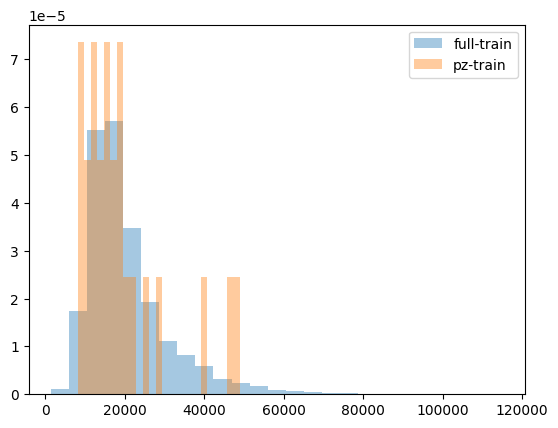

In [686]:
import matplotlib.pyplot as plt

fig
plt.hist(train_text_lengths, density=True, bins=25, alpha=0.4, label='full-train')
plt.hist(val_train_text_lengths, density=True, bins=25, alpha=0.4, label='pz-train')
plt.legend()
plt.show()